In [1]:
import os
import hydra
import logging
import pandas as pd
import joblib
import warnings
import rootutils
import numpy as np
from pathlib import Path
from hydra import compose, initialize
from hydra.core.hydra_config import HydraConfig
from sklearn.metrics import f1_score

rootutils.setup_root(search_from="../", indicator=".project-root", pythonpath=True)

from src.experiment.utils import (
    assign_fold_index,
    plot_confusion_matrix,
    visualize_feature_importance,
    plot_label_distributions,
)
from src.experiment.feature.runner import run_extractors
from src.experiment.metrics import macro_f1_from_proba
from src.experiment.model.runner import train_cv_tabular_v1, predict_cv_tabular_v1
from src.experiment.optimization import find_optimal_threshold_for_label, decode_label
from src.experiment.model.custom_metrics import lgb_macro_auc, lgb_macro_f1

In [2]:
OVERRIDES: list[str] = os.getenv("OVERRIDES", "experiment=007-tabular_v2").split(",")

In [3]:
if OVERRIDES is None:
    raise ValueError("OVERRIDES is not set")

with initialize(version_base=None, config_path="../configs"):
    CFG = compose(
        config_name="config.yaml",
        return_hydra_config=True,
        overrides=OVERRIDES,
    )
    HydraConfig.instance().set_config(CFG)  # use HydraConfig for notebook to use hydra job

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

if not logger.handlers:
    handler = logging.StreamHandler()
    logger.addHandler(handler)


warnings.filterwarnings("ignore")
INPUT_DIR = Path(CFG.paths.input_dir)
OUTPUT_DIR = Path(CFG.paths.output_dir)

### Load Data


In [4]:
def assign_meta(df: pd.DataFrame, data="train"):
    df["data"] = data
    df["fold"] = -1
    return df


train_df = pd.read_csv(INPUT_DIR / "train.csv").rename(columns={"Unnamed: 0": "uid"})
test_df = pd.read_csv(INPUT_DIR / "test.csv").rename(columns={"Unnamed: 0": "uid"})
sample_submission_df = pd.read_csv(INPUT_DIR / "sample_submission.csv")

train_df = assign_meta(train_df, data="train")
test_df = assign_meta(test_df, data="test")

### CV Split


In [5]:
kfold = hydra.utils.instantiate(CFG.cv)
train_df = assign_fold_index(train_df=train_df, kfold=kfold, y_col="health")

### Feature Engineering


In [6]:
feature_extractors = hydra.utils.instantiate(CFG.feature_extractors)

for extractor in CFG.agg_feature_extractors:
    if CFG.group_keys_for_agg is not None:
        for group_keys in CFG.group_keys_for_agg:
            _extractor = hydra.utils.instantiate(extractor, group_keys=group_keys)
            feature_extractors.append(_extractor)

for extractor in CFG.te_feature_extractors:
    if CFG.group_keys_for_te is not None:
        for group_keys in CFG.group_keys_for_te:
            _extractor = hydra.utils.instantiate(extractor, group_keys=group_keys)
            feature_extractors.append(_extractor)

raw_df = pd.concat([train_df, test_df], axis=0, ignore_index=True)
raw_feature_df = run_extractors(
    input_df=raw_df,
    extractors=feature_extractors,
    dirpath=Path(CFG.paths.feature_store_dir),
    fit=True,
    cache=CFG.cache_feature_extractors,
)
assert len(raw_df) == len(raw_feature_df)

raw_feature_df = pd.concat([raw_df, raw_feature_df], axis=1)
train_feature_df = raw_feature_df.query("data == 'train'").reset_index(drop=True)
test_feature_df = raw_feature_df.query("data == 'test'").reset_index(drop=True)

feature_columns = [col for col in train_feature_df.columns if col.startswith("f_")]

<CreatedAtFeatureExtractorV1_44136fa355b3678a1146ad16f7e8649e94fb4fc21fe77e8310c060f61caaff8a>
<CurbLocationFeatureExtractorV1_ffb6a02e825b9d360512f969787b1224531b252c126bdfe37bcd16e4bc25f9e8>
<StreetWidthFeatureExtractorV1_e1934d345bbdbad6b6f154ab09d29008992672b28417152d8b0cc4d67cf97d52>
<GuardsFeatureExtractorV1_32effaf7c5b3c0140641140dbe7f670e6864cab220e3ce069c29ba661bbb756d>
<SidewalkFeatureExtractorV1_11ff165eda5af11f1928f4588c36bd9dd7a3197cf1f18f4f1d741ebc6292d04e>
<UserTypeFeatureExtractorV1_807ed6f844d318d70e501ed5fcef4e2324682fd3d8bd67d9ce65f98c8fd9468f>
<ProblemsFeatureExtractorV1_44136fa355b3678a1146ad16f7e8649e94fb4fc21fe77e8310c060f61caaff8a>
<NtaFeatureExtractorV1_86ddbf901e5c7d2d0ebdda417de8e509407566f742f2645a8e164e236d91989b>
<RawTransformer_ad8f3c0e9af5e37117606a7a14ec4cd3c9595632f93afd5cf9b1a4eea53b0bf5>
<CreatedAtFeatureExtractorV1_44136fa355b3678a1146ad16f7e8649e94fb4fc21fe77e8310c060f61caaff8a>
<TreeDbhFeatureExtractorV1_44136fa355b3678a1146ad16f7e8649e94fb4fc21fe

### Train


In [7]:
def assign_seed_average_pred(result_df: pd.DataFrame) -> pd.DataFrame:
    cols = [col for col in result_df.columns if col.startswith("pred_")]
    pred = 0
    for col in cols:
        pred += np.array(result_df[col].tolist())
    result_df["pred"] = list(pred / len(cols))
    return result_df.reset_index()


valid_result_df = pd.DataFrame()
all_trained_estimators = []
for seed in CFG.seed_average_seeds:
    logger.info(f"\n\nstart training seed={seed} 🚀")
    CFG.model.estimator.random_state = seed

    if CFG.use_cat_features:
        cat_features = [x for x in feature_columns if x.startswith("f_oe_")]
        estimator = hydra.utils.instantiate(CFG.model.estimator, cat_features=cat_features)
    else:
        estimator = hydra.utils.instantiate(CFG.model.estimator)

    fit_params = hydra.utils.instantiate(CFG.model.fit_params)
    if estimator.__class__.__name__.startswith("LGBM"):
        fit_params["eval_metric"] = [lgb_macro_auc, lgb_macro_f1]

    model_output_dir = OUTPUT_DIR / "models" / f"seed{seed}"
    trained_estimators = train_cv_tabular_v1(
        df=train_feature_df,
        estimator=estimator,
        feature_columns=feature_columns,
        target_columns=["health"],
        fit_params=fit_params,
        output_dir=model_output_dir,
        overwrite=CFG.overwrite_training,
    )

    i_valid_result_df = predict_cv_tabular_v1(
        df=train_feature_df,
        estimators=trained_estimators,
        feature_columns=feature_columns,
        predict_proba=False,
    )
    val_score = macro_f1_from_proba(
        y_true=i_valid_result_df["health"],
        y_pred=i_valid_result_df["pred"].tolist(),
    )
    logger.info(f"macro f1 score [seed={seed}]: {val_score}")

    valid_result_df = pd.concat(
        [
            valid_result_df,
            i_valid_result_df[["uid", "pred", "health"]]
            .set_index(["uid", "health"])
            .rename(columns={"pred": f"pred_{seed}"}),
        ],
        axis=1,
    )
    all_trained_estimators.extend(trained_estimators)


valid_result_df = assign_seed_average_pred(valid_result_df)
val_proba = np.array(valid_result_df["pred"].tolist())
val_score = macro_f1_from_proba(y_true=valid_result_df["health"], y_pred=val_proba)

opt_results, val_pred_label = find_optimal_threshold_for_label(
    proba_matrix=val_proba,
    true_labels=valid_result_df["health"],
    label_indices=[2, 0, 1],
)
best_f1_score = f1_score(
    y_true=valid_result_df["health"],
    y_pred=val_pred_label,
    average="macro",
)

logger.info(f"macro f1 score: {val_score}")
logger.info(f"optimized thresholds: {opt_results}")
logger.info(f"best f1 score: {best_f1_score}")

joblib.dump(valid_result_df[["uid", "health", "pred"]], OUTPUT_DIR / "valid_result_df.pkl")



start training seed=0 🚀
start training fold=0 🚀 
estimator : LGBMModel_611cf7c2db63189dee0c85631227fb3454f2a50bfc45dce97c129e00992d357e


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003350 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10955
[LightGBM] [Info] Number of data points in the train set: 17985, number of used features: 180
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_logloss: 1.02428
[200]	valid_0's multi_logloss: 0.983462
[300]	valid_0's multi_logloss: 0.949134
[400]	valid_0's multi_logloss: 0.921898
[500]	valid_0's multi_logloss: 0.899198
[600]	valid_0's multi_logloss: 0.878873
[700]	valid_0's multi_logloss: 0.860026
[800]	valid_0's multi_logloss: 0.843451
[900]	valid_0's multi_logloss: 0.826573
[1000]	valid_0's multi_logloss: 0.80897
[1100]	valid_0's multi

start training fold=1 🚀 
estimator : LGBMModel_611cf7c2db63189dee0c85631227fb3454f2a50bfc45dce97c129e00992d357e


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003030 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10962
[LightGBM] [Info] Number of data points in the train set: 17985, number of used features: 180
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_logloss: 0.993053
[200]	valid_0's multi_logloss: 0.942063
[300]	valid_0's multi_logloss: 0.906923
[400]	valid_0's multi_logloss: 0.876403
[500]	valid_0's multi_logloss: 0.849894
[600]	valid_0's multi_logloss: 0.821874
[700]	valid_0's multi_logloss: 0.804621
[800]	valid_0's multi_logloss: 0.789103
[900]	valid_0's multi_logloss: 0.775804
[1000]	valid_0's multi_logloss: 0.761221
[1100]	valid_0's mul

start training fold=2 🚀 
estimator : LGBMModel_611cf7c2db63189dee0c85631227fb3454f2a50bfc45dce97c129e00992d357e


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003407 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10965
[LightGBM] [Info] Number of data points in the train set: 17985, number of used features: 180
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_logloss: 1.02597
[200]	valid_0's multi_logloss: 0.980656
[300]	valid_0's multi_logloss: 0.943318
[400]	valid_0's multi_logloss: 0.913403
[500]	valid_0's multi_logloss: 0.88875
[600]	valid_0's multi_logloss: 0.863646
[700]	valid_0's multi_logloss: 0.842737
[800]	valid_0's multi_logloss: 0.822166
[900]	valid_0's multi_logloss: 0.80452
[1000]	valid_0's multi_logloss: 0.788512
[1100]	valid_0's multi_

start training fold=3 🚀 
estimator : LGBMModel_611cf7c2db63189dee0c85631227fb3454f2a50bfc45dce97c129e00992d357e


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002859 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10961
[LightGBM] [Info] Number of data points in the train set: 17985, number of used features: 180
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_logloss: 1.00279
[200]	valid_0's multi_logloss: 0.947443
[300]	valid_0's multi_logloss: 0.906461
[400]	valid_0's multi_logloss: 0.877173
[500]	valid_0's multi_logloss: 0.849806
[600]	valid_0's multi_logloss: 0.827214
[700]	valid_0's multi_logloss: 0.800315
[800]	valid_0's multi_logloss: 0.786172
[900]	valid_0's multi_logloss: 0.769539
[1000]	valid_0's multi_logloss: 0.759022
[1100]	valid_0's mult

start training fold=4 🚀 
estimator : LGBMModel_611cf7c2db63189dee0c85631227fb3454f2a50bfc45dce97c129e00992d357e


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003133 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10973
[LightGBM] [Info] Number of data points in the train set: 17986, number of used features: 180
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_logloss: 1.0058
[200]	valid_0's multi_logloss: 0.954982
[300]	valid_0's multi_logloss: 0.921614
[400]	valid_0's multi_logloss: 0.89131
[500]	valid_0's multi_logloss: 0.866629
[600]	valid_0's multi_logloss: 0.841851
[700]	valid_0's multi_logloss: 0.82636
[800]	valid_0's multi_logloss: 0.812138
[900]	valid_0's multi_logloss: 0.797377
[1000]	valid_0's multi_logloss: 0.782221
[1100]	valid_0's multi_l

start training fold=5 🚀 
estimator : LGBMModel_611cf7c2db63189dee0c85631227fb3454f2a50bfc45dce97c129e00992d357e


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003392 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10960
[LightGBM] [Info] Number of data points in the train set: 17986, number of used features: 180
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_logloss: 0.999933
[200]	valid_0's multi_logloss: 0.957525
[300]	valid_0's multi_logloss: 0.921251
[400]	valid_0's multi_logloss: 0.887552
[500]	valid_0's multi_logloss: 0.861744
[600]	valid_0's multi_logloss: 0.837869
[700]	valid_0's multi_logloss: 0.816147
[800]	valid_0's multi_logloss: 0.799391
[900]	valid_0's multi_logloss: 0.784381
[1000]	valid_0's multi_logloss: 0.769826
[1100]	valid_0's mul

start training fold=6 🚀 
estimator : LGBMModel_611cf7c2db63189dee0c85631227fb3454f2a50bfc45dce97c129e00992d357e


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003161 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10958
[LightGBM] [Info] Number of data points in the train set: 17986, number of used features: 180
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_logloss: 1.01709
[200]	valid_0's multi_logloss: 0.979121
[300]	valid_0's multi_logloss: 0.95622
[400]	valid_0's multi_logloss: 0.925849
[500]	valid_0's multi_logloss: 0.896512
[600]	valid_0's multi_logloss: 0.870406
[700]	valid_0's multi_logloss: 0.852711
[800]	valid_0's multi_logloss: 0.835197
[900]	valid_0's multi_logloss: 0.818186
[1000]	valid_0's multi_logloss: 0.805074
[1100]	valid_0's multi

start training fold=7 🚀 
estimator : LGBMModel_611cf7c2db63189dee0c85631227fb3454f2a50bfc45dce97c129e00992d357e


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003221 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10965
[LightGBM] [Info] Number of data points in the train set: 17986, number of used features: 180
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_logloss: 1.0086
[200]	valid_0's multi_logloss: 0.960082
[300]	valid_0's multi_logloss: 0.922799
[400]	valid_0's multi_logloss: 0.896013
[500]	valid_0's multi_logloss: 0.867539
[600]	valid_0's multi_logloss: 0.843391
[700]	valid_0's multi_logloss: 0.822765
[800]	valid_0's multi_logloss: 0.809492
[900]	valid_0's multi_logloss: 0.795862
[1000]	valid_0's multi_logloss: 0.783777
[1100]	valid_0's multi

start training fold=8 🚀 
estimator : LGBMModel_611cf7c2db63189dee0c85631227fb3454f2a50bfc45dce97c129e00992d357e


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003026 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10953
[LightGBM] [Info] Number of data points in the train set: 17986, number of used features: 180
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_logloss: 0.99976
[200]	valid_0's multi_logloss: 0.956284
[300]	valid_0's multi_logloss: 0.911857
[400]	valid_0's multi_logloss: 0.880036
[500]	valid_0's multi_logloss: 0.849839
[600]	valid_0's multi_logloss: 0.830848
[700]	valid_0's multi_logloss: 0.810372
[800]	valid_0's multi_logloss: 0.792676
[900]	valid_0's multi_logloss: 0.775302
[1000]	valid_0's multi_logloss: 0.761597
[1100]	valid_0's mult

start training fold=9 🚀 
estimator : LGBMModel_611cf7c2db63189dee0c85631227fb3454f2a50bfc45dce97c129e00992d357e


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002963 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10971
[LightGBM] [Info] Number of data points in the train set: 17986, number of used features: 180
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_logloss: 1.00598
[200]	valid_0's multi_logloss: 0.95184
[300]	valid_0's multi_logloss: 0.911152
[400]	valid_0's multi_logloss: 0.8723
[500]	valid_0's multi_logloss: 0.844534
[600]	valid_0's multi_logloss: 0.819484
[700]	valid_0's multi_logloss: 0.800946
[800]	valid_0's multi_logloss: 0.780701
[900]	valid_0's multi_logloss: 0.766573
[1000]	valid_0's multi_logloss: 0.753255
[1100]	valid_0's multi_l

fold0 predict : test=False
fold1 predict : test=False
fold2 predict : test=False
fold3 predict : test=False
fold4 predict : test=False
fold5 predict : test=False
fold6 predict : test=False
fold7 predict : test=False
fold8 predict : test=False
fold9 predict : test=False
macro f1 score [seed=0]: 0.3698281131905647
macro f1 score: 0.3698281131905647
optimized thresholds: {2: {'threshold': 0.25252525252525254, 'f1': 0.38008094641483886}, 0: {'threshold': 0.4444444444444445, 'f1': 0.38236562340280433}, 1: {'threshold': 0.4141414141414142, 'f1': 0.38258393125639417}}
best f1 score: 0.38258393125639417


['/Users/masato/Projects/SMBC-Group-GREENxDATA-Challenge/resources/outputs/experiment=007-tabular_v2/valid_result_df.pkl']

### Visualization


Loaded backend module://matplotlib_inline.backend_inline version unknown.
Loaded backend module://matplotlib_inline.backend_inline version unknown.
findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
findfont: score(FontEntry(fname='/Users/masato/Projects/SMBC-Group-GREENxDATA-Challenge/.venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-BoldItalic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
findfont: score(FontEntry(fname='/Users/masato/Projects/SMBC-Group-GREENxDATA-Challenge/.venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/cmr10.ttf', name='cmr10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/Users/masato/Projects/SMBC-Group-GREENxDATA-Challenge/.venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-Bold.ttf', name='DejaV

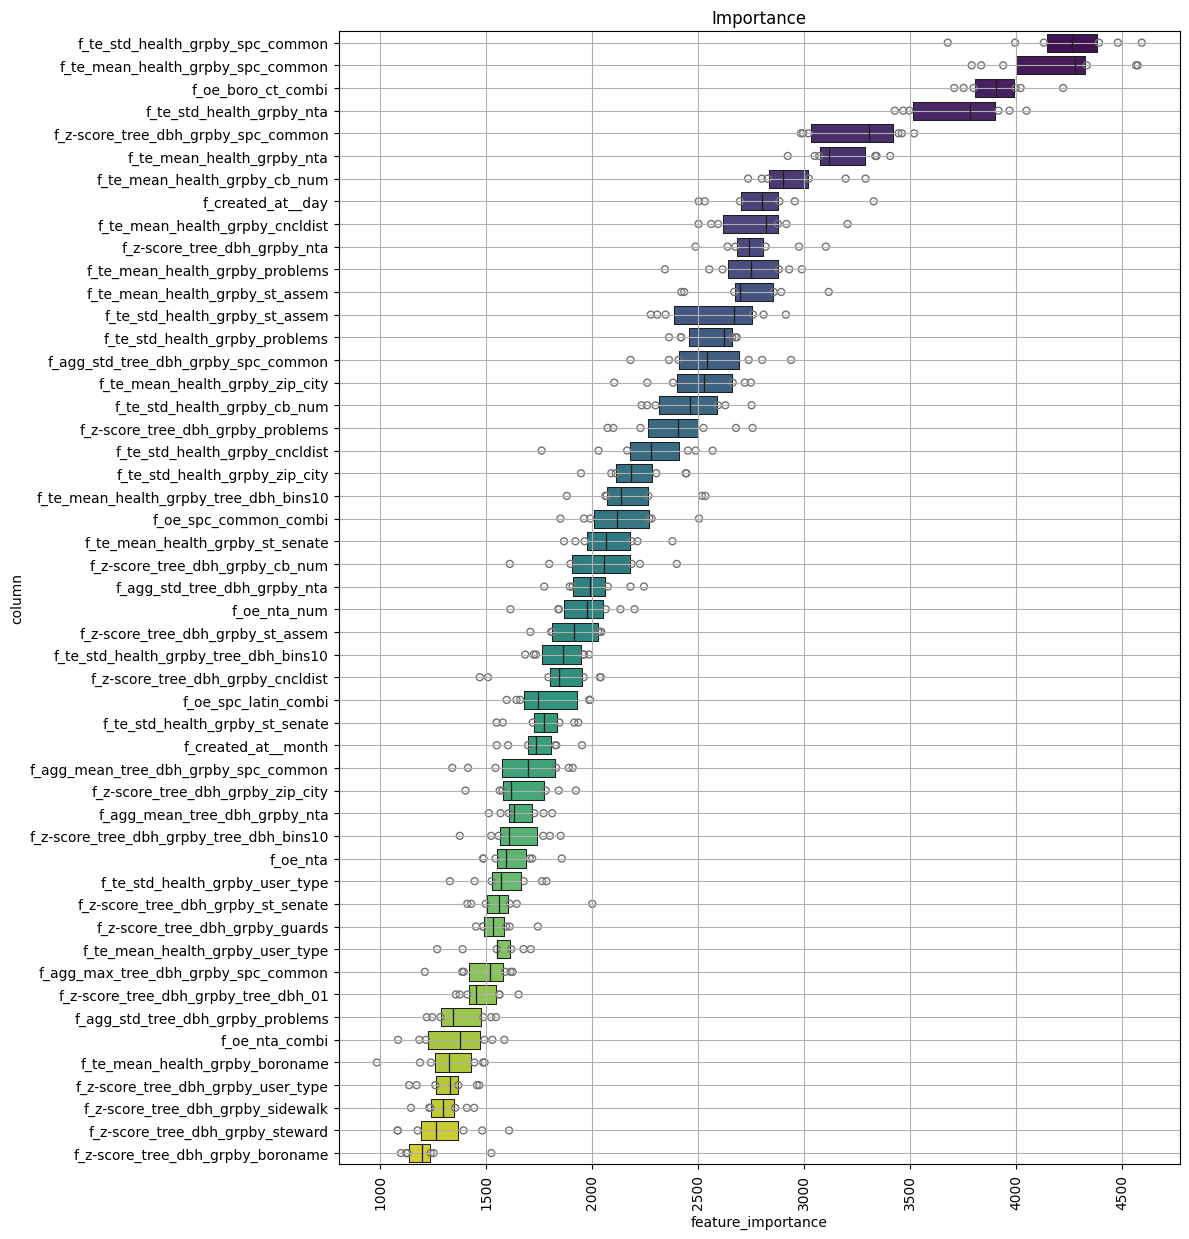

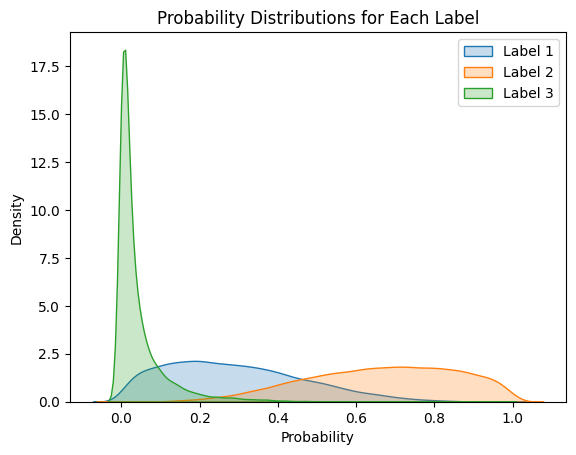

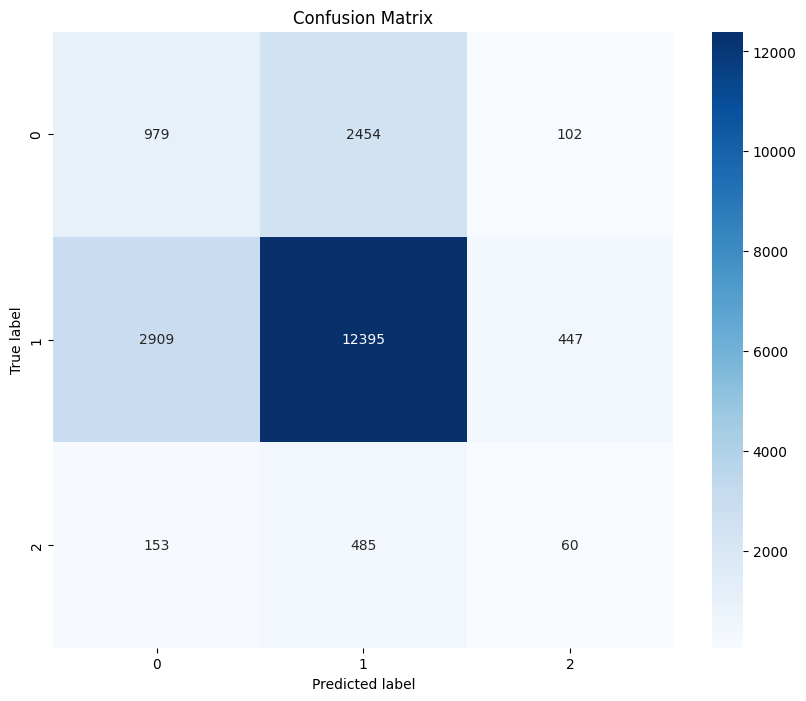

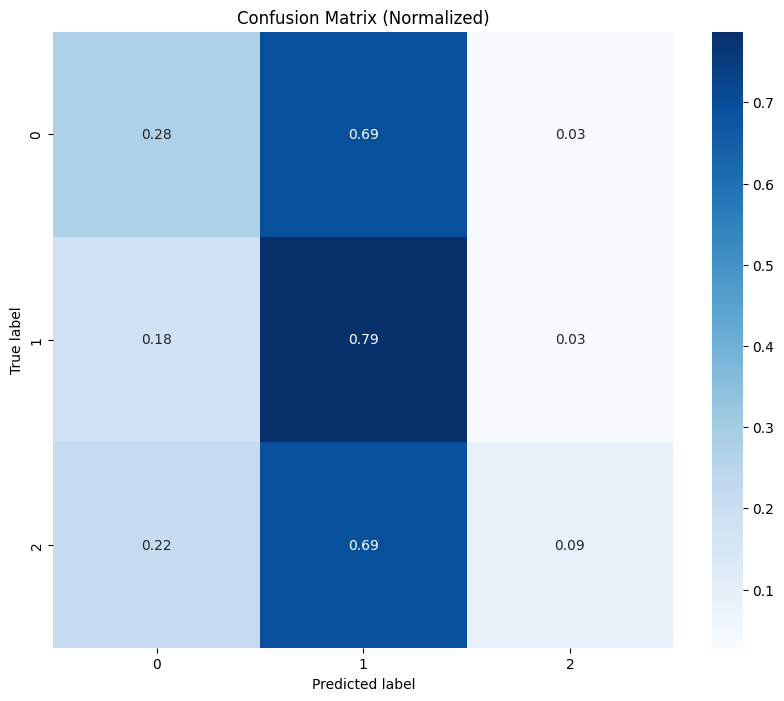

In [8]:
fig, importance_df = visualize_feature_importance(
    estimators=all_trained_estimators,
    feature_columns=feature_columns,
    top_n=50,
)
fig.savefig(OUTPUT_DIR / "feature_importance.png", dpi=300)
importance_df.to_csv(OUTPUT_DIR / "feature_importance.csv", index=False)


fig = plot_label_distributions(proba_matrix=np.array(valid_result_df["pred"].tolist()))
fig.show()
fig.savefig(OUTPUT_DIR / "label_distributions.png", dpi=300)


fig = plot_confusion_matrix(y_true=valid_result_df["health"], y_pred=val_pred_label)
fig.savefig(OUTPUT_DIR / "confusion_matrix.png", dpi=300)

fig = plot_confusion_matrix(y_true=valid_result_df["health"], y_pred=val_pred_label, normalize=True)
fig.savefig(OUTPUT_DIR / "confusion_matrix_normalized.png", dpi=300)

### Make submission


In [9]:
test_result_df = predict_cv_tabular_v1(
    df=test_feature_df,
    estimators=all_trained_estimators,
    feature_columns=feature_columns,
    test=True,
    predict_proba=False,
)

test_pred_df = pd.concat([test_result_df[["uid"]], pd.DataFrame(test_result_df["pred"].tolist())], axis=1)
test_df["pred"] = np.argmax(test_pred_df.groupby("uid").mean(), axis=1)
submission_df = test_df[["uid", "pred"]]
submission_filepath = Path(CFG.paths.output_dir) / f"submissions_{CFG.experiment_name}.csv"
submission_df.to_csv(submission_filepath, index=False, header=False)

fold0 predict : test=True
fold1 predict : test=True
fold2 predict : test=True
fold3 predict : test=True
fold4 predict : test=True
fold5 predict : test=True
fold6 predict : test=True
fold7 predict : test=True
fold8 predict : test=True
fold9 predict : test=True


In [10]:
test_pred_df = pd.concat([test_result_df[["uid"]], pd.DataFrame(test_result_df["pred"].tolist())], axis=1)
test_df["opt_pred"] = decode_label(proba_matrix=test_pred_df.groupby("uid").mean().to_numpy(), thresholds=opt_results)

submission_filepath = Path(CFG.paths.output_dir) / f"submissions_{CFG.experiment_name}_opt.csv"
test_df[["uid", "opt_pred"]].to_csv(submission_filepath, index=False, header=False)

joblib.dump(test_pred_df, OUTPUT_DIR / "test_result_df.pkl")

['/Users/masato/Projects/SMBC-Group-GREENxDATA-Challenge/resources/outputs/experiment=007-tabular_v2/test_result_df.pkl']

In [11]:
test_df["opt_pred"].value_counts()

opt_pred
1    14804
0     4139
2      759
Name: count, dtype: int64

In [12]:
test_df["pred"].value_counts()

pred
1    16325
0     3199
2      178
Name: count, dtype: int64